In [1]:
# Импорт необходимых библиотек
import numpy as np
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

2023-09-28 21:13:49.654413: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-28 21:13:50.011042: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-28 21:13:50.013523: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 21:13:52.639022: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Загрузка CIFAR-10 датасета
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [3]:
# Нормализация изображений
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Преобразование меток в one-hot encoding
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [4]:
# Создание объекта ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [5]:
# Выполнение аугментации данных с использованием datagen
datagen.fit(train_images)

# Пример использования .flow() для обучения модели
# model.fit(datagen.flow(train_images, train_labels, batch_size=32), steps_per_epoch=len(train_images) / 32, epochs=10)

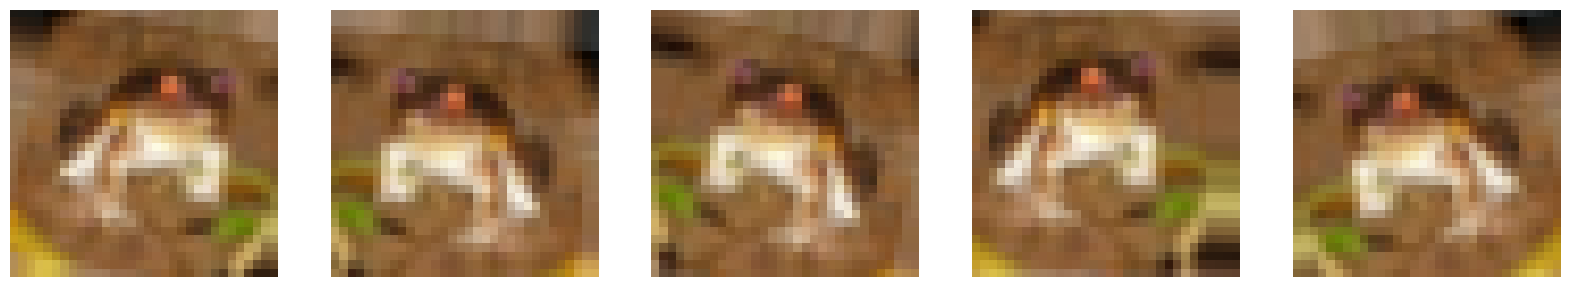

In [6]:
# Генерация аугментированных изображений
augmented_images = [train_images[0] for i in range(5)]
augmented_images = np.array(augmented_images)
augmented_images = datagen.flow(augmented_images, batch_size=5, shuffle=False).next()

# Визуализация изображений
fig, axarr = plt.subplots(1, 5, figsize=(20, 5))

for i in range(5):
    axarr[i].imshow(augmented_images[i])
    axarr[i].axis('off')

plt.show()


In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Определение структуры модели
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)), # Сверточный слой с 32 фильтрами
    MaxPooling2D((2, 2)), # Слой пулинга
    Conv2D(64, (3, 3), activation='relu'), # Следующий сверточный слой с 64 фильтрами
    MaxPooling2D((2, 2)), # Слой пулинга
    Conv2D(64, (3, 3), activation='relu'), # Еще один сверточный слой с 64 фильтрами
    Flatten(), # Преобразование матрицы признаков в вектор
    Dense(64, activation='relu'), # Полносвязный слой
    Dense(10, activation='softmax') # Выходной слой с 10 нейронами (по количеству классов в CIFAR-10)
])

# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Обучение модели
model.fit(datagen.flow(train_images, train_labels, batch_size=32),
          steps_per_epoch=len(train_images) / 32,
          epochs=10,
          validation_data=(test_images, test_labels))


Epoch 1/10
1563/1562 [==============================] - ETA: 0s - loss: 1.6411 - accuracy: 0.3940

2023-09-28 21:15:36.810530: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122880000 exceeds 10% of free system memory.


1562/1562 [==============================] - 51s 32ms/step - loss: 1.6411 - accuracy: 0.3940 - val_loss: 1.3899 - val_accuracy: 0.4929
Epoch 2/10
1562/1562 [==============================] - 49s 31ms/step - loss: 1.3288 - accuracy: 0.5199 - val_loss: 1.2102 - val_accuracy: 0.5733
Epoch 3/10
1562/1562 [==============================] - 49s 31ms/step - loss: 1.1984 - accuracy: 0.5741 - val_loss: 1.0884 - val_accuracy: 0.6164
Epoch 4/10
1562/1562 [==============================] - 49s 31ms/step - loss: 1.1176 - accuracy: 0.6018 - val_loss: 1.0156 - val_accuracy: 0.6403
Epoch 5/10
1562/1562 [==============================] - 46s 30ms/step - loss: 1.0625 - accuracy: 0.6239 - val_loss: 0.9339 - val_accuracy: 0.6710
Epoch 6/10
1562/1562 [==============================] - 47s 30ms/step - loss: 1.0221 - accuracy: 0.6392 - val_loss: 0.9295 - val_accuracy: 0.6774
Epoch 7/10
1562/1562 [==============================] - 46s 29ms/step - loss: 0.9883 - accuracy: 0.6543 - val_loss: 0.8730 - val_accura

1/1 [==============================] - 0s 52ms/step


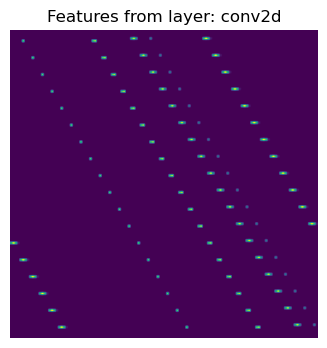

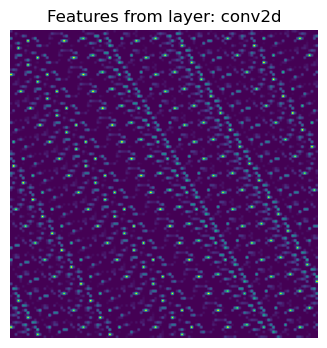

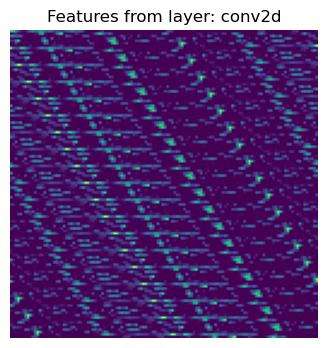

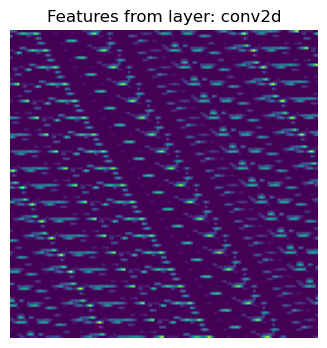

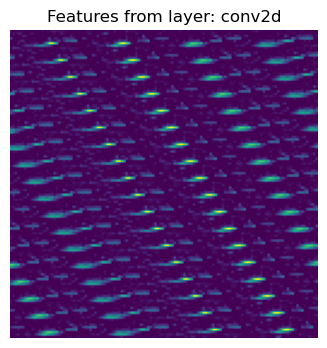

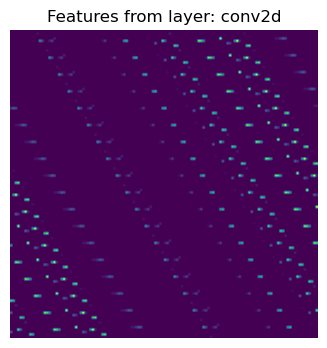

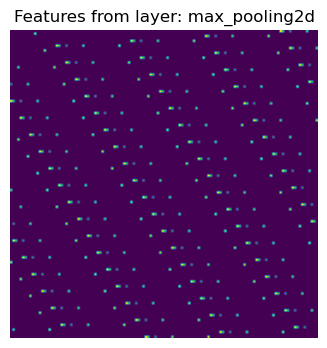

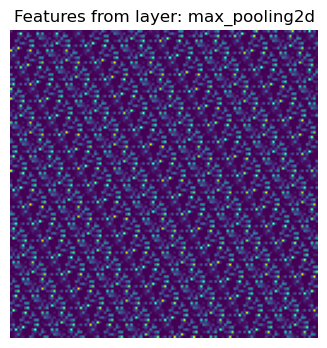

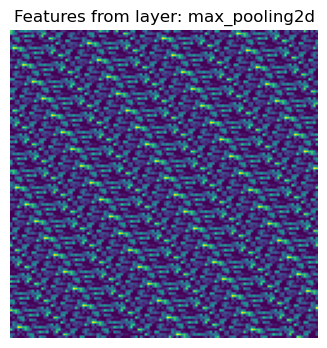

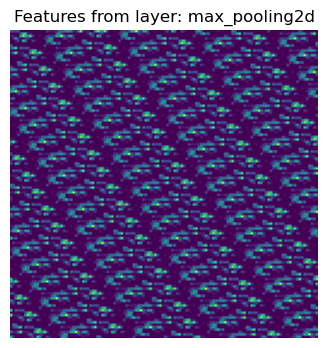

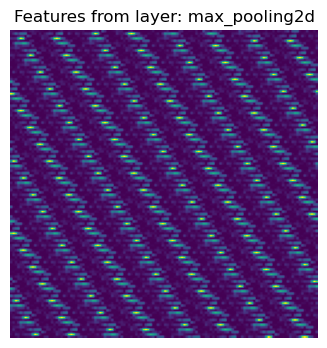

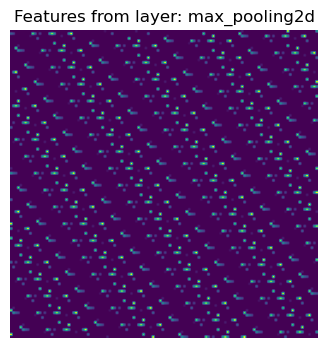

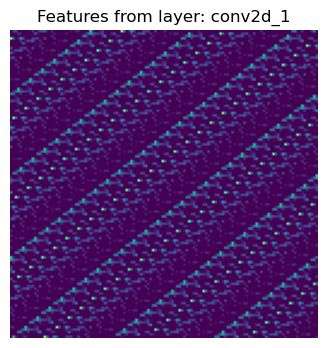

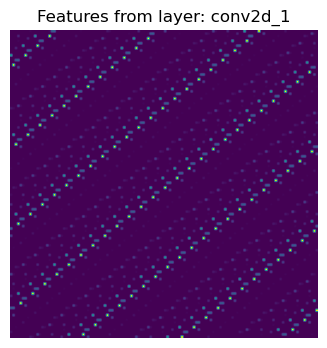

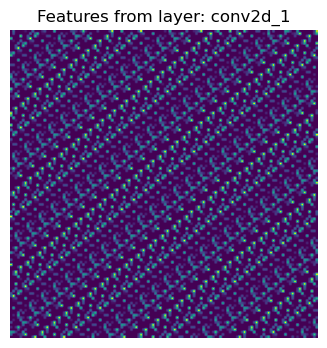

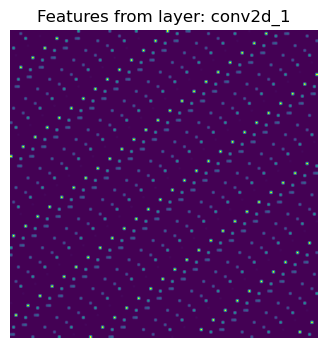

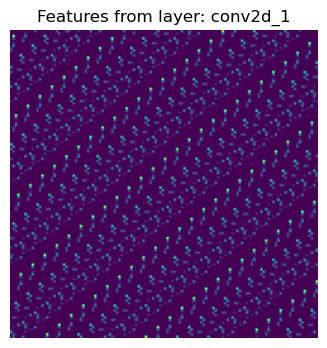

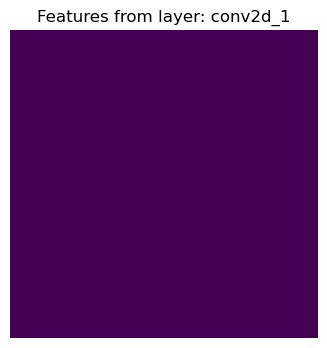

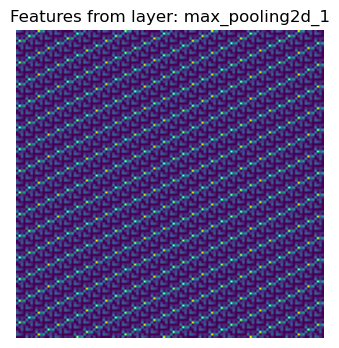

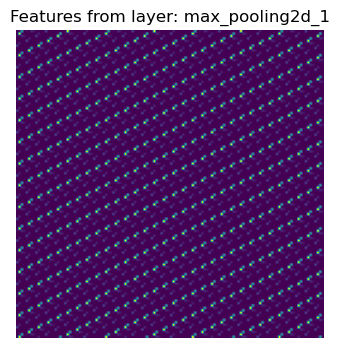

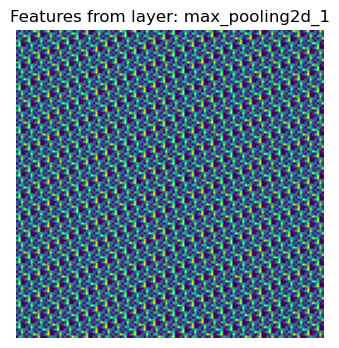

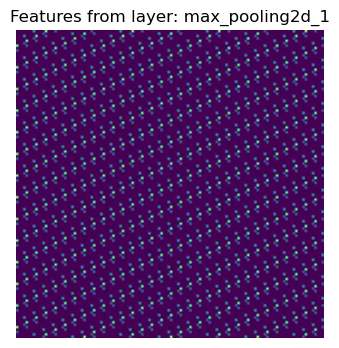

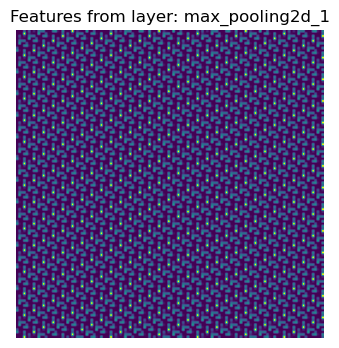

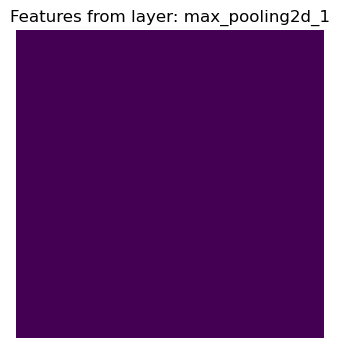

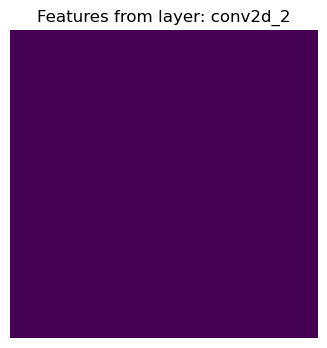

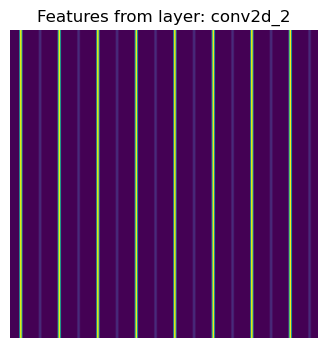

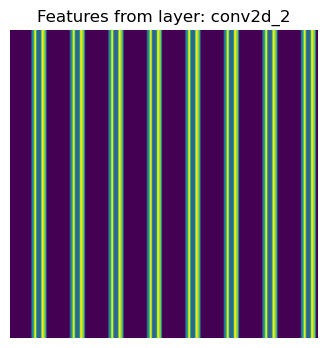

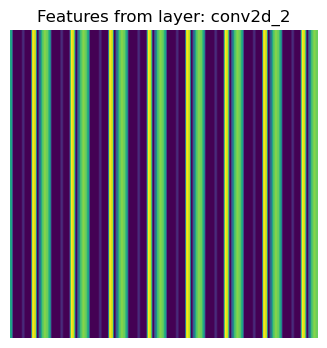

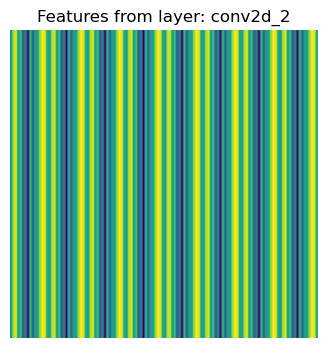

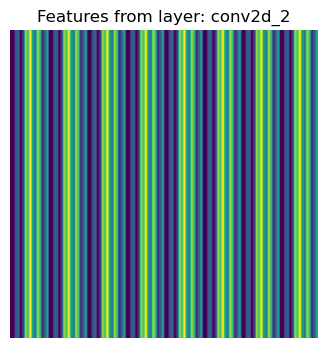

In [15]:
# Выберем одно изображение для визуализации признаков
img = train_images[0]
img = np.expand_dims(img, axis=0)  # расширим измерения для соответствия входному формату модели

# Получим выходные данные каждого слоя для выбранного изображения
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img)

# Функция для интерполяции изображений до размера 128x128
def upscale_to_128x128(img):
    return np.resize(img, (128, 128))

# Визуализация признаков
for layer_name, layer_activation in zip([layer.name for layer in model.layers], activations):
    # Если активация имеет 4 измерения (как в случае с Conv2D и MaxPooling2D)
    if len(layer_activation.shape) == 4:
        # Выберем первые 6 признаковых карт для визуализации
        for i in range(6):
            plt.figure(figsize=(16, 4))
            
            # Некоторые слои могут иметь менее 6 каналов, в таком случае мы визуализируем только имеющиеся
            if layer_activation.shape[-1] >= i+1:
                channel_image = layer_activation[0, :, :, i]
                channel_image = upscale_to_128x128(channel_image)  # Интерполяция до размера 128x128
                plt.imshow(channel_image, cmap='viridis')
                plt.title(f"Features from layer: {layer_name}")
                plt.axis('off')
        plt.show()


In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping

# Определение структуры модели
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)), # Сверточный слой с 32 фильтрами
    MaxPooling2D((2, 2)), # Слой пулинга
    Conv2D(64, (3, 3), activation='relu'), # Следующий сверточный слой с 64 фильтрами
    MaxPooling2D((2, 2)), # Слой пулинга
    Conv2D(64, (3, 3), activation='relu'), # Еще один сверточный слой с 64 фильтрами
    Flatten(), # Преобразование матрицы признаков в вектор
    Dense(64, activation='relu'), # Полносвязный слой
    Dense(10, activation='softmax') # Выходной слой с 10 нейронами (по количеству классов в CIFAR-10)
])

# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Определение каллбека
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)

# Обучение модели
model.fit(datagen.flow(train_images, train_labels, batch_size=32),
          steps_per_epoch=len(train_images) / 32,
          epochs=10,
          validation_data=(test_images, test_labels),
          callbacks=[early_stopping])

Epoch 1/10
1562/1562 [==============================] - 18s 11ms/step - loss: 1.6543 - accuracy: 0.3910 - val_loss: 1.2989 - val_accuracy: 0.5315
Epoch 2/10
1562/1562 [==============================] - 18s 11ms/step - loss: 1.3303 - accuracy: 0.5229 - val_loss: 1.1900 - val_accuracy: 0.5711
Epoch 3/10
1562/1562 [==============================] - 18s 11ms/step - loss: 1.2052 - accuracy: 0.5726 - val_loss: 1.0744 - val_accuracy: 0.6171
Epoch 4/10
1562/1562 [==============================] - 18s 11ms/step - loss: 1.1313 - accuracy: 0.5971 - val_loss: 1.0007 - val_accuracy: 0.6434
Epoch 5/10
1562/1562 [==============================] - 18s 11ms/step - loss: 1.0683 - accuracy: 0.6237 - val_loss: 0.9628 - val_accuracy: 0.6621
Epoch 6/10
1562/1562 [==============================] - 18s 11ms/step - loss: 1.0199 - accuracy: 0.6396 - val_loss: 0.9273 - val_accuracy: 0.6746
Epoch 7/10
1562/1562 [==============================] - 18s 11ms/step - loss: 0.9969 - accuracy: 0.6476 - val_loss: 0.9473 -

In [17]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Определение структуры модели
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)), # Сверточный слой с 32 фильтрами
    MaxPooling2D((2, 2)), # Слой пулинга
    Conv2D(64, (3, 3), activation='relu'), # Следующий сверточный слой с 64 фильтрами
    MaxPooling2D((2, 2)), # Слой пулинга
    Conv2D(64, (3, 3), activation='relu'), # Еще один сверточный слой с 64 фильтрами
    Flatten(), # Преобразование матрицы признаков в вектор
    Dense(64, activation='relu'), # Полносвязный слой
    Dense(10, activation='softmax') # Выходной слой с 10 нейронами (по количеству классов в CIFAR-10)
])

# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Определение каллбеков
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)

# Обучение модели
model.fit(datagen.flow(train_images, train_labels, batch_size=32),
          steps_per_epoch=len(train_images) / 32,
          epochs=10,
          validation_data=(test_images, test_labels),
          callbacks=[early_stopping, reduce_lr])


Epoch 1/10
1562/1562 [==============================] - 18s 12ms/step - loss: 1.6297 - accuracy: 0.4040 - val_loss: 1.2810 - val_accuracy: 0.5310 - lr: 0.0010
Epoch 2/10
1562/1562 [==============================] - 18s 12ms/step - loss: 1.3086 - accuracy: 0.5307 - val_loss: 1.1684 - val_accuracy: 0.5739 - lr: 0.0010
Epoch 3/10
1562/1562 [==============================] - 18s 12ms/step - loss: 1.1918 - accuracy: 0.5754 - val_loss: 1.1124 - val_accuracy: 0.6035 - lr: 0.0010
Epoch 4/10
1562/1562 [==============================] - 18s 12ms/step - loss: 1.1166 - accuracy: 0.6043 - val_loss: 1.0040 - val_accuracy: 0.6394 - lr: 0.0010
Epoch 5/10
1562/1562 [==============================] - 19s 12ms/step - loss: 1.0640 - accuracy: 0.6232 - val_loss: 1.0123 - val_accuracy: 0.6413 - lr: 0.0010
Epoch 6/10
1562/1562 [==============================] - 19s 12ms/step - loss: 1.0127 - accuracy: 0.6431 - val_loss: 0.9416 - val_accuracy: 0.6716 - lr: 0.0010
Epoch 7/10
1562/1562 [========================

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
import datetime

# Определение структуры модели
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)), # Сверточный слой с 32 фильтрами
    MaxPooling2D((2, 2)), # Слой пулинга
    Conv2D(64, (3, 3), activation='relu'), # Следующий сверточный слой с 64 фильтрами
    MaxPooling2D((2, 2)), # Слой пулинга
    Conv2D(64, (3, 3), activation='relu'), # Еще один сверточный слой с 64 фильтрами
    Flatten(), # Преобразование матрицы признаков в вектор
    Dense(64, activation='relu'), # Полносвязный слой
    Dense(10, activation='softmax') # Выходной слой с 10 нейронами (по количеству классов в CIFAR-10)
])

# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Определение каллбеков
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)

# Добавление TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Обучение модели
model.fit(datagen.flow(train_images, train_labels, batch_size=32),
          steps_per_epoch=len(train_images) / 32,
          epochs=10,
          validation_data=(test_images, test_labels),
          callbacks=[early_stopping, reduce_lr, tensorboard_callback])

Epoch 1/10
1562/1562 [==============================] - 19s 12ms/step - loss: 1.6338 - accuracy: 0.4007 - val_loss: 1.2945 - val_accuracy: 0.5328 - lr: 0.0010
Epoch 2/10
1562/1562 [==============================] - 18s 12ms/step - loss: 1.3221 - accuracy: 0.5239 - val_loss: 1.1331 - val_accuracy: 0.5928 - lr: 0.0010
Epoch 3/10
1562/1562 [==============================] - 18s 12ms/step - loss: 1.2117 - accuracy: 0.5644 - val_loss: 1.0927 - val_accuracy: 0.6158 - lr: 0.0010
Epoch 4/10
1562/1562 [==============================] - 18s 12ms/step - loss: 1.1271 - accuracy: 0.5990 - val_loss: 1.0640 - val_accuracy: 0.6247 - lr: 0.0010
Epoch 5/10
1562/1562 [==============================] - 19s 12ms/step - loss: 1.0671 - accuracy: 0.6235 - val_loss: 1.0431 - val_accuracy: 0.6488 - lr: 0.0010
Epoch 6/10
1562/1562 [==============================] - 18s 12ms/step - loss: 1.0260 - accuracy: 0.6353 - val_loss: 0.9448 - val_accuracy: 0.6692 - lr: 0.0010
Epoch 7/10
1562/1562 [========================

In [19]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
import datetime

# Определение структуры модели
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)), # Сверточный слой с 32 фильтрами
    MaxPooling2D((2, 2)), # Слой пулинга
    Conv2D(64, (3, 3), activation='relu'), # Следующий сверточный слой с 64 фильтрами
    MaxPooling2D((2, 2)), # Слой пулинга
    Conv2D(64, (3, 3), activation='relu'), # Еще один сверточный слой с 64 фильтрами
    Flatten(), # Преобразование матрицы признаков в вектор
    Dense(64, activation='relu'), # Полносвязный слой
    Dense(10, activation='softmax') # Выходной слой с 10 нейронами (по количеству классов в CIFAR-10)
])

# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Определение каллбеков
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)

# Добавление TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Добавление ModelCheckpoint callback
best_model_path = "best_model.h5"
checkpoint_callback = ModelCheckpoint(best_model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
